In [ ]:
#@title Import Library
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# Augmentasi gambar
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

# Evaluasi confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import files
from tensorflow.keras.models import load_model


In [ ]:
#@title Download Dataset
!gdown --fuzzy https://drive.google.com/file/d/1hUnDCr5Svm4dxzVDMBNsai0d3vFWRzMR/view?usp=drive_link -O ds811_lettuce_r.zip

!unzip /content/ds811_lettuce_r.zip -d /content

Downloading...
From: https://drive.google.com/uc?id=1hUnDCr5Svm4dxzVDMBNsai0d3vFWRzMR
To: /content/ds811_lettuce_r.zip
100% 7.99M/7.99M [00:00<00:00, 74.3MB/s]
Archive:  /content/ds811_lettuce_r.zip
   creating: /content/ds811_lettuce_r/
   creating: /content/ds811_lettuce_r/test/
   creating: /content/ds811_lettuce_r/test/Healthy/
  inflating: /content/ds811_lettuce_r/test/Healthy/lh(13).jpg  
  inflating: /content/ds811_lettuce_r/test/Healthy/lh(15).jpg  
  inflating: /content/ds811_lettuce_r/test/Healthy/lh(2).jpg  
  inflating: /content/ds811_lettuce_r/test/Healthy/lh(21).jpg  
  inflating: /content/ds811_lettuce_r/test/Healthy/lh(40).jpg  
  inflating: /content/ds811_lettuce_r/test/Healthy/lh(53).jpg  
  inflating: /content/ds811_lettuce_r/test/Healthy/lh(57).jpg  
  inflating: /content/ds811_lettuce_r/test/Healthy/lh(71).jpg  
  inflating: /content/ds811_lettuce_r/test/Healthy/lh(74).jpg  
  inflating: /content/ds811_lettuce_r/test/Healthy/lh(91).jpg  
   creating: /content/ds811

In [ ]:
# @title Pengaturan Keras agar hasil dapat direproduksi kembali

# import random

# SEED = 0

# def set_seeds(seed=SEED):
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     random.seed(seed)
#     tf.random.set_seed(seed)
#     np.random.seed(seed)

# def set_global_determinism(seed=SEED):
#     set_seeds(seed=seed)

#     os.environ['TF_DETERMINISTIC_OPS'] = '1'
#     os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

#     tf.config.threading.set_inter_op_parallelism_threads(1)
#     tf.config.threading.set_intra_op_parallelism_threads(1)

# # Call the above function with seed value
# set_global_determinism(seed=SEED)

In [ ]:
#@title Fungsi Ambil direktori Dataset
def get_path_ds(data_dir):
  train_dir = f'{data_dir}/train'
  test_dir = f'{data_dir}/test'

  return train_dir, test_dir

In [ ]:
#@title Fungsi Augmentasi
def augmentation_ds(val_split):
  aug_train = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=val_split
  )

  aug_val = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale=1.0 / 255,
      validation_split=val_split
  )

  rescale_test = rescale = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1.0 / 255
  )


  return aug_train, aug_val, rescale_test


In [ ]:
#@title Persiapan Dataset untuk Data latih
def preparing_ds(function, bs, ts, cm = "sparse", trdir='', tsdir=''):

   aug_train, aug_val, rescale_test = function()

   train_ds = aug_train.flow_from_directory(
        trdir,
        target_size=ts,
        batch_size=bs,
        class_mode= cm,
        shuffle=True,
        seed=123,
        subset="training"
    )

   val_ds = aug_val.flow_from_directory(
        trdir,
        target_size =ts,
        batch_size =bs,
        class_mode= cm,
        shuffle=True,
        seed=123,
        subset="validation"
    )

   test_ds = rescale_test.flow_from_directory(
        tsdir,
        batch_size = bs,
        target_size= ts,
        shuffle = False
    )

   classes = list(train_ds.class_indices.keys())

   n_classes = train_ds.num_classes

   return train_ds, val_ds, test_ds, classes, n_classes


In [ ]:
#@title Fungsi Kurva Pembelajaran & Confusion Matrix
def learning_curve(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))
  fig = plt.figure(figsize=(15,10))
  grid = plt.GridSpec(2, 2, wspace=0.2, hspace = 0.3, figure =fig)

  plt.subplot(grid[0,0])
  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.legend()

  plt.subplot(grid[0,1])
  plt.plot(epochs, loss, 'r', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and Validation loss')
  plt.legend()

  # menampilkan grafik
  plt.show()

def evaluation_confusion_matrix(model, data):
  # test_steps_per_epoch = np.math.ceil(data.samples / data.batch_size)
  predictions = model.predict(data, verbose=0)

  # Get most likely class
  predicted_classes = np.argmax(predictions, axis=1)

  true_classes = data.classes
  class_labels = list(data.class_indices.keys())
  cf_matrix = confusion_matrix(true_classes, predicted_classes)
  report_cf_matrix = classification_report(true_classes, predicted_classes, target_names=class_labels)

  return cf_matrix, report_cf_matrix

def cf_matrix_heatmap(cf_matrix, classes):
  plt.figure(figsize=(12,8))
  sns.set(font_scale=0.7)
  ax=sns.heatmap(cf_matrix, annot=True, cmap='Greens')

  # set x-axis label and title
  ax.set_xlabel("Prediksi", fontsize=10, labelpad=2)
  ax.xaxis.set_ticklabels(classes)

  # set y-axis label and title
  ax.set_ylabel("Aktual", fontsize=10, labelpad=2)
  ax.yaxis.set_ticklabels(classes)

  ax.set_title("Confusion Matrix Kualitas Selada", fontsize=12, pad=14)

  plt.show()


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=4,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=30,
)

In [ ]:
def ev(hist, model, test):
  learning_curve(hist)

  cf_matrix_1, report_cf_matrix_1 = evaluation_confusion_matrix(model, test)

  print(report_cf_matrix_1)

  # cf_matrix_heatmap(cf_matrix_1, classes_1)

In [ ]:
#@title Ambil Direktori Dataset
train_dir, test_dir = get_path_ds('/content/ds811_lettuce_r')

In [ ]:
#@title Persiapan Dataset untuk Data Latih
train_ds, val_ds, test_ds, classes, n_classes = preparing_ds(
    lambda : augmentation_ds(0.1),
    bs = 10,
    ts = (256,256),
    cm= "sparse",
    trdir = train_dir,
    tsdir= test_dir
)

Found 367 images belonging to 5 classes.
Found 39 images belonging to 5 classes.
Found 47 images belonging to 5 classes.


In [ ]:
#@title Menampilkan Kelas
classes

['Healthy', 'Mildew', 'MinNutrition', 'Random', 'Rot']

In [ ]:
# @title Arsitektur Model

input_shape = (256,256,3)
epochs_ = 50
step_epoch = np.math.floor(train_ds.samples / train_ds.batch_size)
val_step = np.math.floor(val_ds.samples/val_ds.batch_size)



model_6 = tf.keras.models.Sequential([
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D(2,2),
    layers.Dropout(0.25),
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPool2D(2,2),
    layers.Dropout(0.25),
    layers.Conv2D(128,(3,3), activation = 'relu'),
    layers.MaxPool2D(2,2),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.35),
    layers.Dense(n_classes, activation='softmax')
])

# konfig

model_6.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005),
    metrics=['accuracy']
)


hist_6 = model_6.fit(
    train_ds,
    validation_data= val_ds,
    epochs= epochs_,
    verbose = 1,
    steps_per_epoch= step_epoch,
    validation_steps= val_step,
    callbacks = [early_stopping]
)


Epoch 1/50
36/36 [==============================] - 9s 188ms/step - loss: 1.7675 - accuracy: 0.2129 - val_loss: 1.5886 - val_accuracy: 0.2000
Epoch 2/50
36/36 [==============================] - 6s 155ms/step - loss: 1.3848 - accuracy: 0.3529 - val_loss: 1.2323 - val_accuracy: 0.5000
Epoch 3/50
36/36 [==============================] - 6s 173ms/step - loss: 1.2456 - accuracy: 0.4510 - val_loss: 1.3314 - val_accuracy: 0.6000
Epoch 4/50
36/36 [==============================] - 7s 184ms/step - loss: 1.0881 - accuracy: 0.5350 - val_loss: 1.0275 - val_accuracy: 0.5000
Epoch 5/50
36/36 [==============================] - 6s 156ms/step - loss: 1.0940 - accuracy: 0.5406 - val_loss: 1.0551 - val_accuracy: 0.5333
Epoch 6/50
36/36 [==============================] - 6s 157ms/step - loss: 1.0164 - accuracy: 0.5742 - val_loss: 1.1360 - val_accuracy: 0.6333
Epoch 7/50
36/36 [==============================] - 6s 158ms/step - loss: 0.9896 - accuracy: 0.5910 - val_loss: 0.9856 - val_accuracy: 0.6000
Epoch 

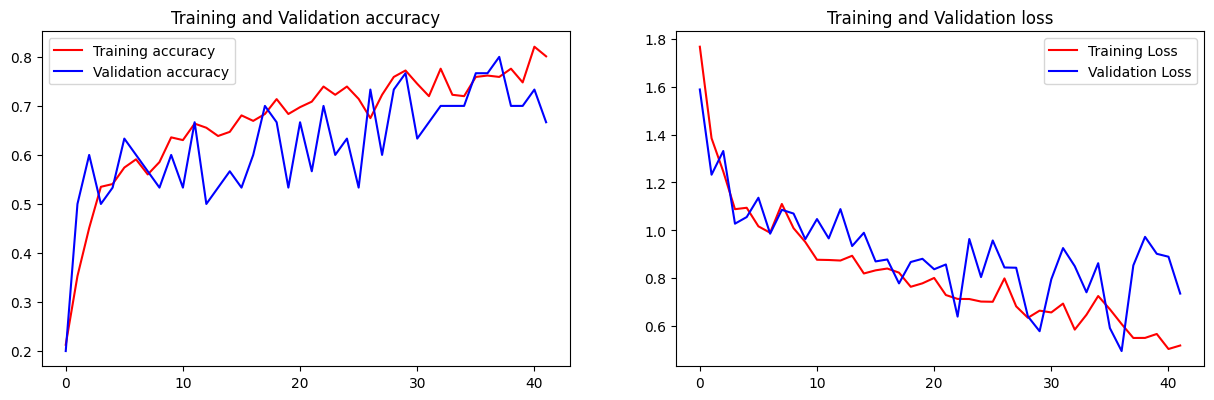

              precision    recall  f1-score   support

     Healthy       0.73      0.80      0.76        10
      Mildew       0.89      0.89      0.89         9
MinNutrition       0.73      0.80      0.76        10
      Random       0.86      0.67      0.75         9
         Rot       0.89      0.89      0.89         9

    accuracy                           0.81        47
   macro avg       0.82      0.81      0.81        47
weighted avg       0.81      0.81      0.81        47



In [ ]:
ev(hist_6, model_6, test_ds)

In [ ]:
#@title Download Model

!gdown --fuzzy https://drive.google.com/file/d/1TzuoaS_Joknxk8u0Gb4R_eVFS6XeS_Sk/view?usp=drive_link -O model.h5


Downloading...
From: https://drive.google.com/uc?id=1TzuoaS_Joknxk8u0Gb4R_eVFS6XeS_Sk
To: /content/model.h5
100% 40.2M/40.2M [00:00<00:00, 284MB/s]


In [ ]:
#@title Load Model

path_model='/content/model.h5'

model = load_model(path_model)

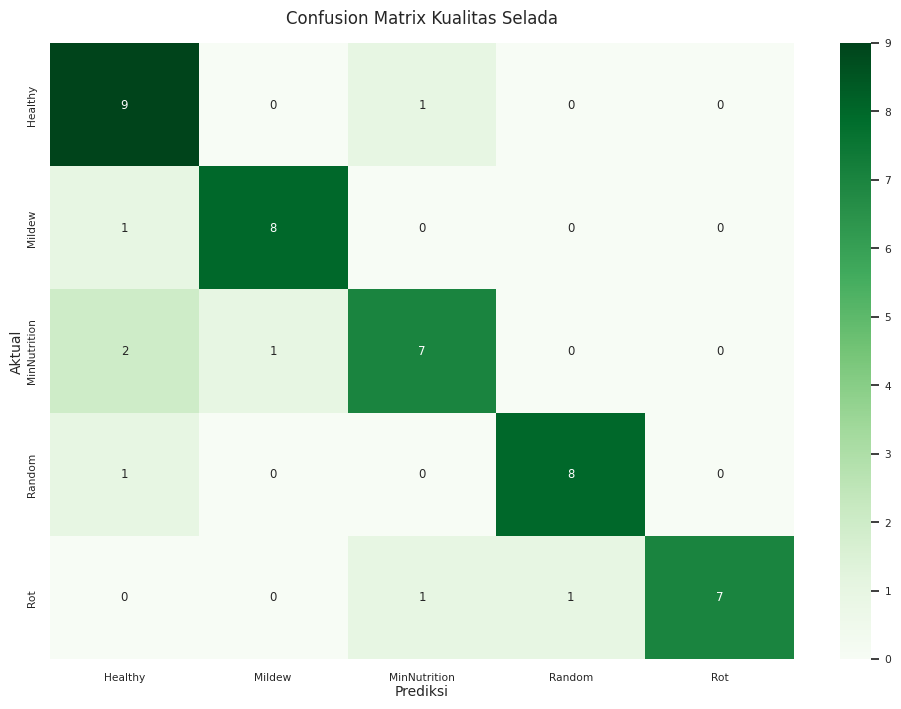

In [ ]:
cf_matrix, _ = evaluation_confusion_matrix(model, test_ds)

cf_matrix_heatmap(cf_matrix, classes)

Saving download (7).jpg to download (7).jpg


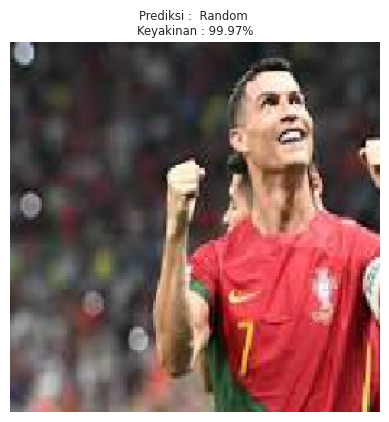

In [ ]:
# @title Input Gambar Selada

uploaded = files.upload()
for fn in uploaded.keys():
  path = fn
  img = tf.keras.utils.load_img(path, target_size=(256,256))
  x = tf.keras.utils.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x /= 255
  images = np.vstack([x])
  pred = model.predict(images, batch_size=8, verbose=0)
  plt.imshow(img)
  prediction = classes[np.argmax(pred)]
  confidence = round(100 * (np.max(pred[0])), 2)
  plt.title(f'Prediksi :  {prediction} \nKeyakinan : {confidence}%')
  plt.axis('off')
